In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download deadskull7/fer2013

 92% 89.0M/96.6M [00:01<00:00, 74.1MB/s]
100% 96.6M/96.6M [00:01<00:00, 90.8MB/s]


In [3]:
! unzip fer2013.zip

Archive:  fer2013.zip
  inflating: fer2013.csv             


In [4]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import torch.optim as optim
import math
import time
from IPython.display import Audio
from IPython.display import Image
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing

df = pd.read_csv('fer2013.csv', sep=',', index_col=None)  # Loading the dataset in a Pandas Dataframe
df['pixels']=df['pixels'].apply(lambda arr: np.array([float(x) for x in arr.split(" ")]))  #Converting pixels data from string to integer arrays
df['pixels']=df['pixels'].apply(lambda arr: np.reshape(arr,(48,48)))   #Converting pixels data from int arrays to 2d numpy arrays of size (48,48)
classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')

# Spliting the dataframe to train, validation and test dataframes
df_train=df[df['Usage']=="Training"]
df_test=df[df['Usage']=="PrivateTest"]

# Extracting the raw data and the lables for each set
train_data = np.asarray([x[0] for x in df_train.drop(columns= ['emotion','Usage'],axis=1).values]).reshape(-1,1,48,48)
train_labels=df_train["emotion"].values

test_data = np.asarray([x[0] for x in df_test.drop(columns= ['emotion','Usage'],axis=1).values]).reshape(-1,1,48,48)
test_labels=df_test["emotion"].values

class mini_batch:
    size=1

In [5]:
torch.cuda.get_device_name(0)

'Tesla K80'

[[[117. 116. 113. ...  45.  45.  45.]
  [118. 116. 114. ...  46.  46.  45.]
  [118. 117. 115. ...  45.  46.  46.]
  ...
  [ 30.  29.  29. ...  58.  55.  55.]
  [ 31.  28.  28. ...  50.  52.  54.]
  [ 33.  28.  28. ...  46.  47.  49.]]] <class 'numpy.ndarray'>
0 = Angry


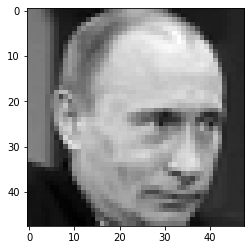

In [6]:
# an example of 1 sample from our training data
print(train_data[65], type(train_data[65]))
print(f"{train_labels[65]} = {classes[train_labels[65]]}")
plt.imshow(train_data[65].squeeze(),cmap='gray')

In [7]:
f=F.relu

def create_dataloaders(train_data, test_data):
    #Creating Datasets and Dataloaders
    train_set=TensorDataset(torch.from_numpy(train_data.astype('float32')),torch.tensor(train_labels))
    test_set=TensorDataset(torch.from_numpy(test_data.astype('float32')),torch.tensor(test_labels))
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=mini_batch.size, shuffle=True, num_workers=2,pin_memory=True) #Because we want to compare different architectures we want to minimize the impact of randomness
    test_loader= torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2,pin_memory=True)
    
    
    return train_loader,test_loader


def train(network, criterion,optimizer,epochs_num, Train_loader, activation_func):
    losses=[]
    for epoch in range(epochs_num):  # Looping over the dataset three times
        running_loss = 0.0
        for i, (X_train,y_train) in enumerate(Train_loader, 0):
            inputs, labels = X_train.cuda(),y_train.cuda() # The input data is a list [inputs, labels]
            optimizer.zero_grad() # Setting the parameter gradients to zero
            outputs = network(inputs,activation_func)  # Forward pass
            loss = criterion(outputs,labels)  # Applying the criterion
            loss.backward() # Backward pass
            optimizer.step() # Optimization step

            running_loss += loss.item() # Updating the running loss
        losses.append(running_loss/mini_batch.size)
        
        running_loss = 0.0
    
    return losses

    
# Calculating the accuracy of the network on the whole dataset
def check_accuracy(activation_func, net, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data # Getting the test data
            images, labels = images.cuda(), labels.cuda()
            outputs = net(images,activation_func) # Getting the network output
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    percentage=100 * correct / total    
    return percentage



def show_some(activation_func):
    dataiter = iter(test_loader) # Iterator over the testing set
    images, labels = dataiter.next()
    outputs=net(images, activation_func)
    
    # Printing the ground truth images and labels
    fig=plt.figure(figsize=(48,48))
    for i in range(1,mini_batch.size+1):
        fig.add_subplot(1,mini_batch.size,i)
        plt.imshow(images[i-1].squeeze(),cmap='gray')
    plt.show()

    _, predicted = torch.max(outputs, 1)
        
    print([classes[i] for i in labels])
    print([classes[i] for i in predicted])  

# 1st Architecture: As we have used in class for CIFAR-10

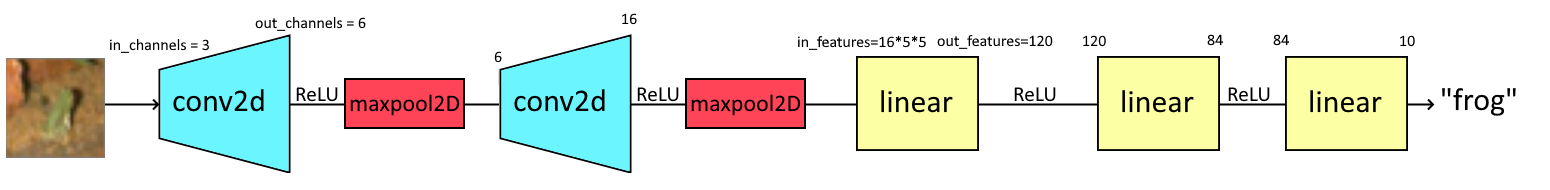

In [8]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.model =nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6,kernel_size=5),  # 1st convolutional layer
        nn.ReLU(),                                               # Activation function 
        nn.MaxPool2d(kernel_size=2,stride=2),                    # Pooling layer

        nn.Conv2d(in_channels=6, out_channels=16,kernel_size=5), # 2nd convolutional layer
        nn.ReLU(),                                               # Activation function 
        nn.MaxPool2d(kernel_size=2,stride=2),                    # Pooling layer

        nn.Flatten(),
        nn.Linear(16*9*9,120),                                  # 1st linear layer
        nn.ReLU(),                                              # Activation function 
        nn.Linear(120,84),                                      # 2nd linear layer
        nn.ReLU(),                                              # Activation function 
        nn.Linear(84,10))                                       # 3rd linear layer
           
    def forward(self, x,activation_func):
        return self.model(x)

In [9]:
mini_batch.size=8
net = Net1()
print()
if torch.cuda.is_available():
    net.cuda()
train_loader,test_loader=create_dataloaders(train_data,test_data)
criterion = nn.CrossEntropyLoss() # Defining the criterion
optimizer = optim.SGD(net.parameters(),lr=0.0001,momentum=0.9)# Defining the optimizer

start = time.time()
train(net,criterion,optimizer,3,train_loader,f)
end = time.time()
accuracy=check_accuracy(f,net,test_loader)

print(f"Accuracy: {math.floor(accuracy)}%\nTime: {math.floor(end - start)} seconds")


Accuracy: 46%
Time: 61 seconds


### 1) Standardization
We will now standartrize our dataset as we have learned in class using the sklearn package.

In [10]:
train_data = np.asarray([x[0] for x in df_train.drop(columns= ['emotion','Usage'],axis=1).values]).reshape(-1,2304)
train_scaler = preprocessing.StandardScaler().fit(train_data)   # Creating a standartization scaler for the train set

test_data = np.asarray([x[0] for x in df_test.drop(columns= ['emotion','Usage'],axis=1).values]).reshape(-1,2304)
test_scaler = preprocessing.StandardScaler().fit(test_data)   # Creating a standartization scaler for the test set

train_scaled = train_scaler.transform(train_data).reshape(-1,1,48,48)   # Standardization for the train set
test_scaled = test_scaler.transform(test_data).reshape(-1,1,48,48)   # Standardization for the test set

train_data=train_data.reshape(-1,1,48,48)
test_data=test_data.reshape(-1,1,48,48)

In [11]:
mini_batch.size=8
net = Net1()
if torch.cuda.is_available():
    net.cuda()
train_loader,test_loader=create_dataloaders(train_scaled,test_scaled)
criterion = nn.CrossEntropyLoss() # Defining the criterion
optimizer = optim.SGD(net.parameters(),lr=0.0001,momentum=0.9)# Defining the optimizer

start = time.time()
train(net,criterion,optimizer,3,train_loader,f)
end = time.time()
accuracy=check_accuracy(f,net,test_loader)

print(f"Accuracy: {math.floor(accuracy)}%\nTime: {math.floor(end - start)} seconds")

Accuracy: 35%
Time: 60 seconds


We see a drop in accuracy and no time change. We will go back to the original data

### 2) The Learning Rate
We will compare different learning rates to see the change in 
loss

In [12]:
mini_batch.size=256
losses,accuracies,times=[],[],[]
net = Net1()
if torch.cuda.is_available():
    net.cuda()
train_loader,test_loader=create_dataloaders(train_data,test_data)
criterion = nn.CrossEntropyLoss() # Defining the criterion

alphas=[0.0001,0.001,0.005,0.01,0.1,1]

for a in alphas:
    start = time.time()    
    optimizer = optim.SGD(net.parameters(),lr=a,momentum=0.9)# Defining the optimizer
    losses.append(train(net,criterion,optimizer,10,train_loader,f))
    end = time.time()
    times.append(math.floor(end-start))
    accuracies.append(check_accuracy(f,net,test_loader))

[[0.8341640834696591, 0.791136160492897, 0.7800869517959654, 0.7694603665731847, 0.7603578842245042, 0.751013686414808, 0.7449978436343372, 0.7369628367014229, 0.728705273475498, 0.721664204262197], [0.7322029871866107, 0.6978928805328906, 0.6767187253572047, 0.6604096465744078, 0.645746948197484, 0.6291625155135989, 0.6167716402560472, 0.6039537214674056, 0.5936782900243998, 0.5813519079238176], [0.8094609449617565, 0.6982713462784886, 0.6603058413602412, 0.6327711972407997, 0.6048053973354399, 0.5751721234992146, 0.5505283819511533, 0.5325939883477986, 0.5049881529994309, 0.49032711680047214], [0.5377063662745059, 0.5165586294606328, 0.49998199893161654, 0.46487425407394767, 0.43969531264156103, 0.4423539799172431, 0.39539921656250954, 0.3760879603214562, 0.37436054600402713, 0.3382050381042063], [0.8116299968678504, 0.8009987687692046, 0.802755887620151, 0.8012042338959873, 0.8022039174102247, 0.8012480079196393, 0.8004264431074262, 0.8007036647759378, 0.8004116746596992, 0.80076888

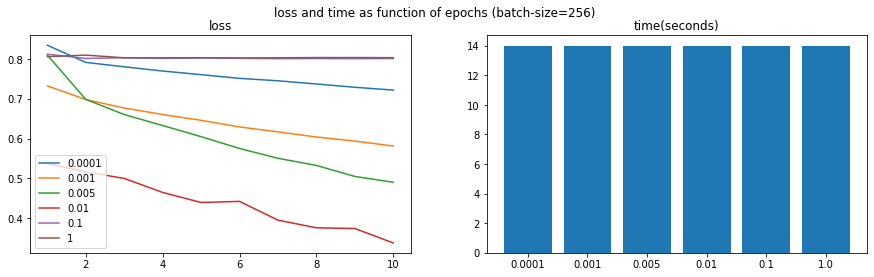

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('loss')
ax2.set_title('time(seconds)')
fig.suptitle('loss and time as function of epochs (batch-size=256)')
for i in range(len(alphas)):
    ax1.plot(range(1,len(losses[i])+1),losses[i],label=str(alphas[i]))
ax2.bar(range(len(alphas)),times,tick_label=alphas)
ax1.legend([str(a) for a in alphas])

print(losses)

fig.set_figwidth(15)

In [14]:
mini_batch.size=8
losses,accuracies,times=[],[],[]
net = Net1()
if torch.cuda.is_available():
    net.cuda()
train_loader,test_loader=create_dataloaders(train_data,test_data)
criterion = nn.CrossEntropyLoss() # Defining the criterion

alphas=[0.0001,0.001,0.005,0.01,0.1,1]

for a in alphas:
    start = time.time()    
    optimizer = optim.SGD(net.parameters(),lr=a,momentum=0.9)# Defining the optimizer
    losses.append(train(net,criterion,optimizer,10,train_loader,f))
    end = time.time()
    times.append(math.floor(end-start))
    accuracies.append(check_accuracy(f,net,test_loader))

[[761.2755394354463, 688.7398674860597, 650.6101315394044, 620.5067109949887, 593.6270833164454, 567.8650021329522, 543.433968886733, 517.4694746360183, 489.31260916776955, 460.63631492014974], [711.5027695968747, 671.1985751241446, 639.3722304925323, 617.0678339600563, 603.2852460592985, 589.095914080739, 578.9954286441207, 566.9413299448788, 562.2924785651267, 553.6213836129755], [816.1621891893446, 814.6761125326157, 814.608498737216, 814.016899779439, 813.9100214987993, 813.5029695183039, 813.1042353659868, 813.1520415395498, 813.7428827434778, 812.9854265153408], [814.4112418889999, 814.5922222733498, 814.2026205956936, 814.177325040102, 813.8102792203426, 814.8568765968084, 815.7708152979612, 813.9441750794649, 813.4130393713713, 812.8492746502161], [823.7776832133532, 823.4695139378309, 824.2439705729485, 824.4898327887058, 822.8533623218536, 824.2509899735451, 822.9327487200499, 823.5975832343102, 824.1156073510647, 823.4135407358408], [951.223054766655, 938.1528083533049, 943.

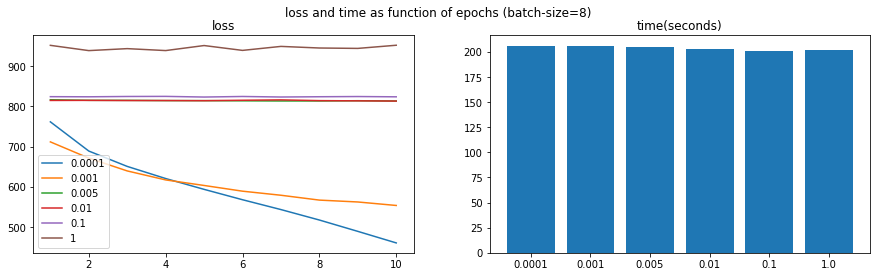

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('loss')
ax2.set_title('time(seconds)')
fig.suptitle('loss and time as function of epochs (batch-size=8)')
for i in range(len(alphas)):
    ax1.plot(range(1,len(losses[i])+1),losses[i],label=str(alphas[i]))
ax2.bar(range(len(alphas)),times,tick_label=alphas)
ax1.legend([str(a) for a in alphas])

print(losses)

fig.set_figwidth(15)

### 3) mini-batch size

In [16]:
batch_sizes=[1,32,256,1024,2048,8192]
learning_rates=[0.0001,0.001,0.005,0.01,0.1,1]
batch_map={}
for i in range(len(batch_sizes)):
  batch_map[batch_sizes[i]]=learning_rates[i]

In [17]:
batches={}
for x in batch_map:
    mini_batch.size=x
    net = Net1()
    if torch.cuda.is_available():
      net.cuda()
    train_loader,test_loader=create_dataloaders(train_data,test_data)
    criterion = nn.CrossEntropyLoss() # Defining the criterion
    optimizer = optim.SGD(net.parameters(),lr=batch_map[x],momentum=0.9)# Defining the optimizer
    start=time.time()
    train(net,criterion,optimizer,10,train_loader,f)
    end=time.time()
    batches[mini_batch.size]=[check_accuracy(f,net,test_loader),round(end-start)]

In [18]:
for batch in batches:
    print(f"Size {batch}: Accuracy={round(batches[batch][0])}, time={batches[batch][1]} seconds")

Size 1: Accuracy=30, time=1588 seconds
Size 32: Accuracy=48, time=56 seconds
Size 256: Accuracy=24, time=15 seconds
Size 1024: Accuracy=28, time=13 seconds
Size 2048: Accuracy=14, time=13 seconds
Size 8192: Accuracy=24, time=15 seconds


## 2nd Architecture
Let's move to the next architecture while maintaing some of the parameters we have collected in the previous architecture

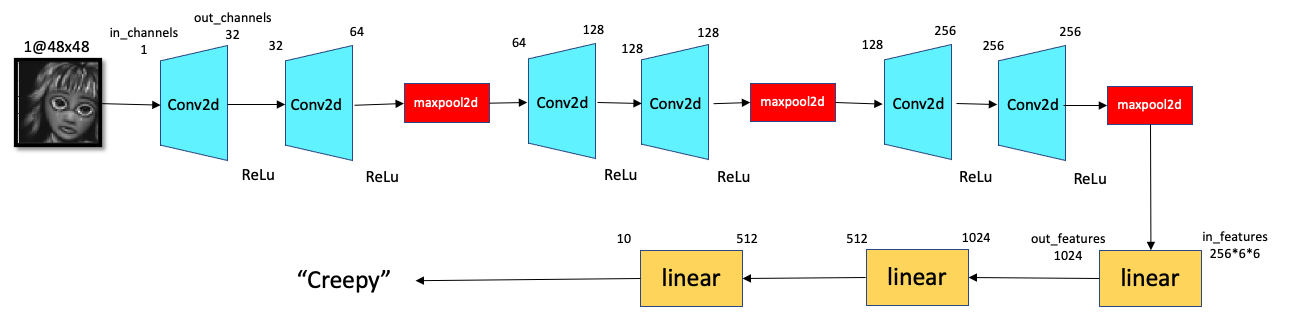

In [19]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.model =nn.Sequential(
                    nn.Conv2d(1,16,kernel_size=3,padding=1),                 # 1st convolutional layer
                    nn.ReLU(),                                               # Activation function 
                    nn.Conv2d(16,64,kernel_size=3,stride=1,padding=1),       # 2nd convolutional layer
                    nn.ReLU(),                                               # Activation function 
                    nn.MaxPool2d(2,2),                                       # Pooling layer

                    nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),      # 3rd convolutional layer
                    nn.ReLU(),                                               # Activation function 
                    nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),     # 4th convolutional layer
                    nn.ReLU(),                                               # Activation function 
                    nn.MaxPool2d(2,2),                                       # Pooling layer

                    nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),     # 5th convolutional layer
                    nn.ReLU(),                                               # Activation function 
                    nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),     # 6th convolutional layer
                    nn.ReLU(),                                               # Activation function 
                    nn.MaxPool2d(2,2),                                       # Pooling layer

                    nn.Flatten(),
                    nn.Linear(256*6*6,1024),                            # 1st linear layer
                    nn.ReLU(),                                          # Activation function 
                    nn.Linear(1024,512),                                # 2nd linear layer
                    nn.ReLU(),                                          # Activation function 
                    nn.Linear(512,10))                                  # 3rd linear layer
        
    def forward(self, x,activation_func):
        return self.model(x)

In [20]:
mini_batch.size=32

net2 = Net2()
if torch.cuda.is_available():
    net2.cuda()
train_loader,test_loader=create_dataloaders(train_data,test_data)
criterion = nn.CrossEntropyLoss() # Defining the criterion
optimizer = optim.SGD(net2.parameters(),lr=0.001,momentum=0.9)# Defining the optimizer
start=time.time()
losses_net2=train(net2,criterion,optimizer,19,train_loader,f)
end=time.time()
accuracies_net2=check_accuracy(F.relu,net2,test_loader)

The model is: 59% accurate and it took 796 seconds to train it


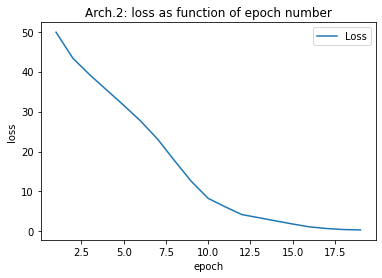

In [21]:
print(f"The model is: {math.floor(accuracies_net2)}% accurate and it took {round(end-start)} seconds to train it")
plt.plot(range(1,len(losses_net2)+1),losses_net2)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Arch.2: loss as function of epoch number')
plt.legend(["Loss"])
plt.show()


## 5) Activation Function
So far we have used ReLU as an activation function for our different models. Let's try the Leacky ReLU as our activation and see if the small difference between the functions translates into a major change in performance.

In [22]:
class Net2_Leaky(nn.Module):
    def __init__(self):
        super(Net2_Leaky, self).__init__()
        self.model =nn.Sequential(
                    nn.Conv2d(1,16,kernel_size=3,padding=1),                 # 1st convolutional layer
                    nn.LeakyReLU(),                                               # Activation function 
                    nn.Conv2d(16,64,kernel_size=3,stride=1,padding=1),       # 2nd convolutional layer
                    nn.LeakyReLU(),                                               # Activation function 
                    nn.MaxPool2d(2,2),                                       # Pooling layer

                    nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),      # 3rd convolutional layer
                    nn.LeakyReLU(),                                               # Activation function 
                    nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),     # 4th convolutional layer
                    nn.LeakyReLU(),                                               # Activation function 
                    nn.MaxPool2d(2,2),                                       # Pooling layer

                    nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),     # 5th convolutional layer
                    nn.LeakyReLU(),                                               # Activation function 
                    nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),     # 6th convolutional layer
                    nn.LeakyReLU(),                                               # Activation function 
                    nn.MaxPool2d(2,2),                                       # Pooling layer

                    nn.Flatten(),
                    nn.Linear(256*6*6,1024),                            # 1st linear layer
                    nn.LeakyReLU(),                                          # Activation function 
                    nn.Linear(1024,512),                                # 2nd linear layer
                    nn.LeakyReLU(),                                          # Activation function 
                    nn.Linear(512,10))                                  # 3rd linear layer
        
    def forward(self, x,activation_func):
        return self.model(x)

In [23]:
mini_batch.size=32

net2_leaky = Net2_Leaky()
if torch.cuda.is_available():
    net2_leaky.cuda()
train_loader,test_loader=create_dataloaders(train_data,test_data)
criterion = nn.CrossEntropyLoss() # Defining the criterion
optimizer = optim.SGD(net2_leaky.parameters(),lr=0.001,momentum=0.9)# Defining the optimizer
start=time.time()
losses_net2_leaky=train(net2_leaky,criterion,optimizer,19,train_loader,F.leaky_relu)
end=time.time()
accuracies_net2_leaky=check_accuracy(F.leaky_relu,net2_leaky,test_loader)

The model is: 58% accurate and it took 807 seconds to train it


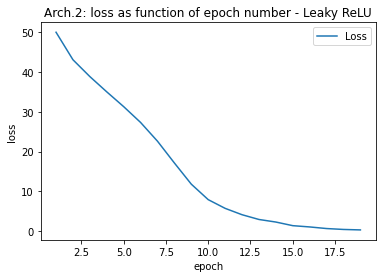

In [24]:
print(f"The model is: {math.floor(accuracies_net2_leaky)}% accurate and it took {round(end-start)} seconds to train it")
plt.plot(range(1,len(losses_net2)+1),losses_net2_leaky)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Arch.2: loss as function of epoch number - Leaky ReLU')
plt.legend(["Loss"])
plt.show()

## 3rd Architecture
In this architecture I have added before each max-pooling another convolutional layer which doesn''t make any change in the number of channels that goes into it(e.g: in_channels=out_channels).

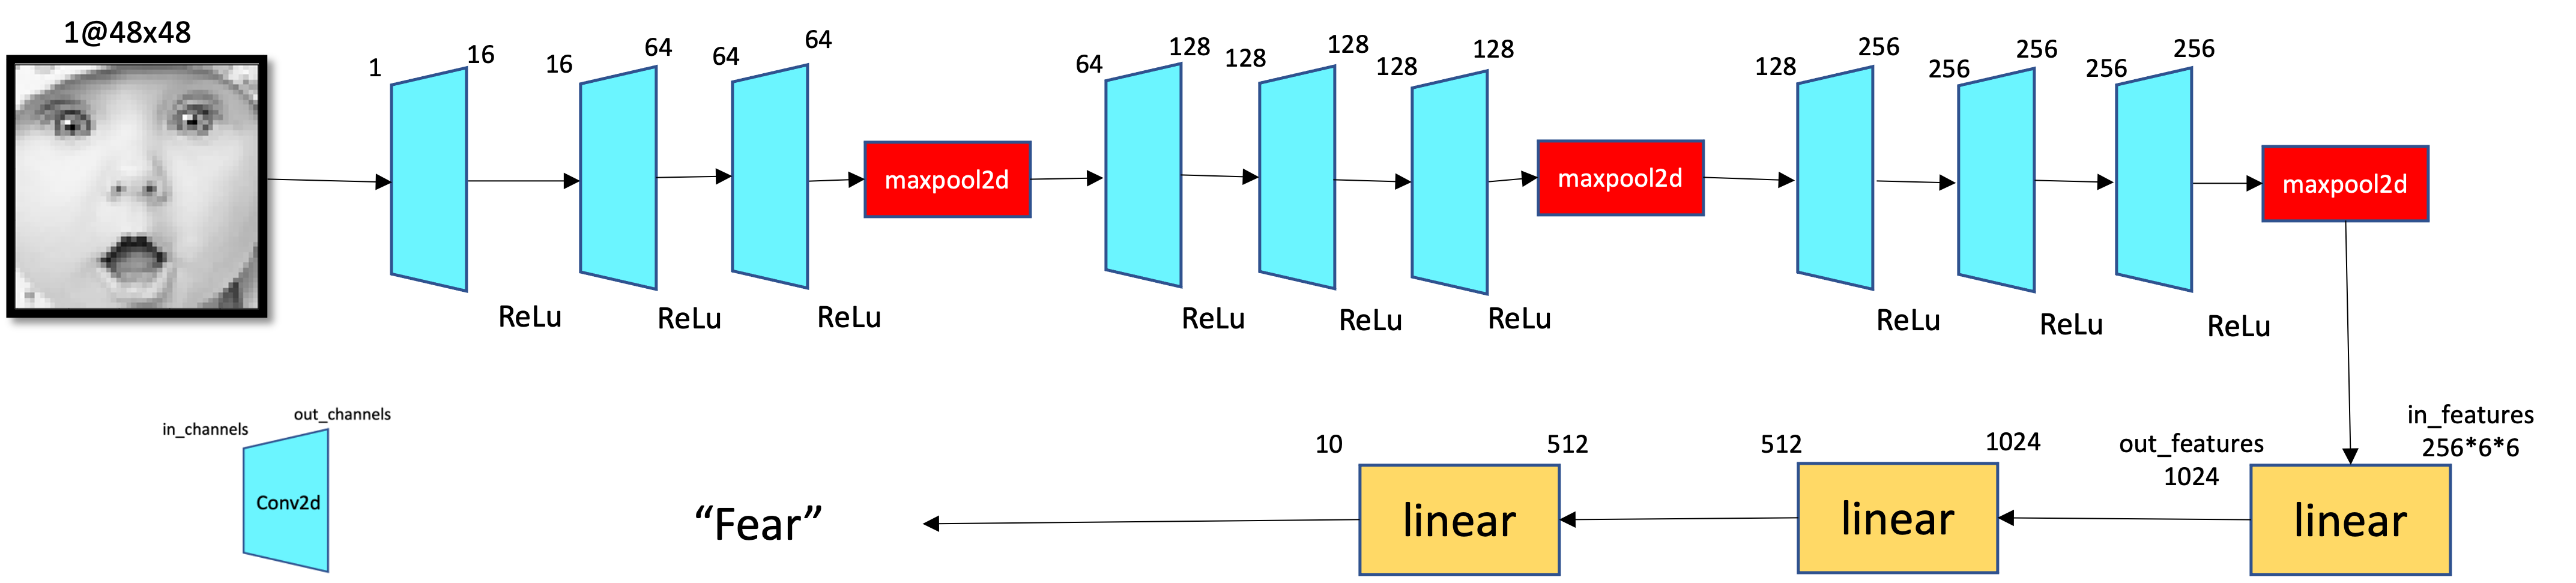

In [25]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.model =nn.Sequential(
                    nn.Conv2d(1,16,kernel_size=3,padding=1),                 # 1st convolutional layer
                    nn.ReLU(),                                               # Activation function 
                    nn.Conv2d(16,64,kernel_size=3,stride=1,padding=1),       # 2nd convolutional layer
                    nn.ReLU(),                                               # Activation function 
                    nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),       # 3rd convolutional layer
                    nn.ReLU(),                                               # Activation function 
                    nn.MaxPool2d(2,2),                                       # Pooling layer

                    nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),      # 3rd convolutional layer
                    nn.ReLU(),                                               # Activation function 
                    nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),     # 4th convolutional layer
                    nn.ReLU(),                                               # Activation function
                    nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),     # 4th convolutional layer
                    nn.ReLU(),                                               # Activation function 
                    nn.MaxPool2d(2,2),                                       # Pooling layer

                    nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),     # 5th convolutional layer
                    nn.ReLU(),                                               # Activation function 
                    nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),     # 6th convolutional layer
                    nn.ReLU(),                                               # Activation function
                    nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),     # 4th convolutional layer
                    nn.ReLU(),                                               # Activation function 
                    nn.MaxPool2d(2,2),                                       # Pooling layer

                    nn.Flatten(),
                    nn.Linear(256*6*6,1024),                            # 1st linear layer
                    nn.ReLU(),                                          # Activation function 
                    nn.Linear(1024,512),                                # 2nd linear layer
                    nn.ReLU(),                                          # Activation function 
                    nn.Linear(512,10))                                  # 3rd linear layer
        
    def forward(self, x,activation_func):
        return self.model(x)

In [26]:
mini_batch.size=32

net3 = Net3()
if torch.cuda.is_available():
    net3.cuda()
train_loader,test_loader=create_dataloaders(train_data,test_data)
criterion = nn.CrossEntropyLoss() # Defining the criterion
optimizer = optim.SGD(net3.parameters(),lr=0.001,momentum=0.9)# Defining the optimizer
start=time.time()
losses_net3=train(net3,criterion,optimizer,19,train_loader,f)
end=time.time()

The model is: 55% accurate and it took 1266 seconds to train it


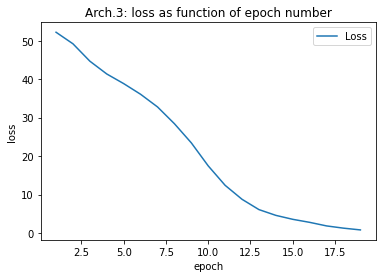

In [27]:
print(f"The model is: {math.floor(check_accuracy(F.relu,net3,test_loader))}% accurate and it took {round(end-start)} seconds to train it")
plt.plot(range(1,len(losses_net3)+1),losses_net3)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Arch.3: loss as function of epoch number')
plt.legend(["Loss"])
plt.show()
